# Continuity Analysis

In [1]:
# data loading
from aif_gen.dataset.continual_alignment_dataset import ContinualAlignmentDataset

lipschitz_data = ContinualAlignmentDataset.from_json(
    'data/4omini_generation/merged_tech_physics.json'
)
piecewise_data = ContinualAlignmentDataset.from_json(
    'data/4omini_generation/merged_politics_generate.json'
)

# only get the prompts shuffled and only 10K prompts
data_lip = lipschitz_data.datasets[0].samples
data_piecewise = piecewise_data.datasets[0].samples

prompts_lip = []
for sample in data_lip:
    prompts_lip.append(sample.prompt)

# randomly shuffle the prompts and keep only 10K
import random

random.shuffle(prompts_lip)
prompts_lip = prompts_lip[:10000]

prompts_piecewise = []
for sample in data_piecewise:
    prompts_piecewise.append(sample.prompt)
# randomly shuffle the prompts and keep only 10K
random.shuffle(prompts_piecewise)
prompts_piecewise = prompts_piecewise[:10000]
print(prompts_piecewise[:10])
print(prompts_lip[:10])

/home/mila/s/shahrad.mohammadzadeh/projects/AIF-Gen/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


["In today's political landscape, the role of committees in shaping legislation cannot be understated. Committees serve as the backbone of governmental operations, providing thorough analysis and debate on proposed laws before they reach the wider  body. One particularly notable instance is when the Majority Party in Congress leverages committee power to drive its agenda. When the Majority Party controls a committee, they often prioritize legislation that aligns with their platform, leading to significant developments in areas like healthcare, education, and infrastructure.\n\nThe Majority can effectively steer discussions and influence the trajectory of policy by selecting which bills to advance. For example, if a bill aimed at expanding public healthcare is brought to the Health Committee, a committee led by Majority Party members may fast-track it for a vote or, conversely, sink it in reviews. This majority dominance can result in substantial shifts in governmental priorities, poten

||T12|| = 0.86,  ||T23|| = 0.83


Interp T12: 100%|██████████| 11/11 [13:07<00:00, 71.56s/it]


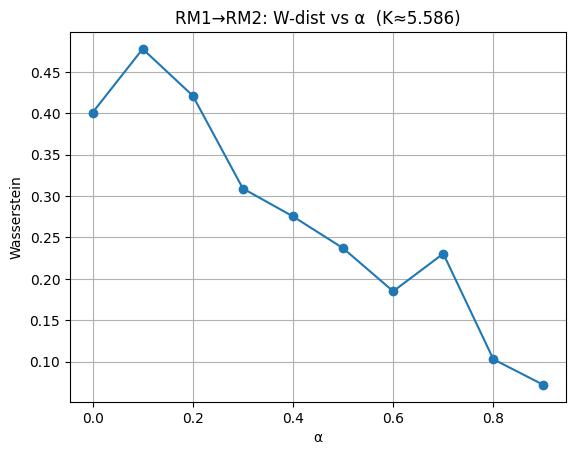

Interp T23: 100%|██████████| 11/11 [13:05<00:00, 71.39s/it]


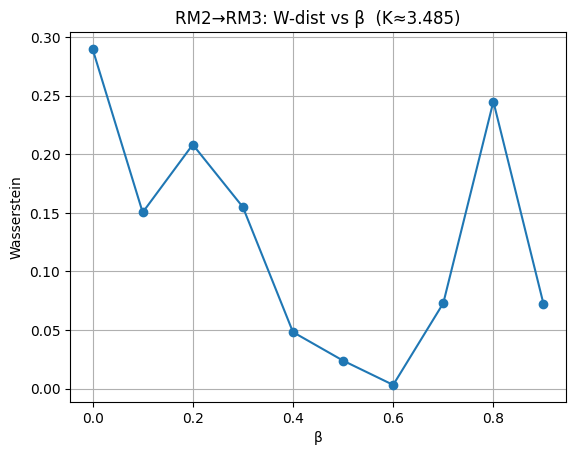

Empirical Lipschitz constants: K12=5.5859, K23=3.4846


In [2]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# -----------------------------------------------------------------------------
# Utilities for state‐dict arithmetic & norms
# -----------------------------------------------------------------------------
def subtract_state_dicts(sd_a, sd_b):
    return {k: sd_a[k] - sd_b[k] for k in sd_a}


def add_scaled(sd_base, sd_delta, alpha):
    return {k: sd_base[k] + alpha * sd_delta[k] for k in sd_base}


def state_dict_norm(sd):
    total = torch.stack([v.flatten().dot(v.flatten()) for v in sd.values()]).sum()
    return torch.sqrt(total).item()


# -----------------------------------------------------------------------------
# Load your 3 reward models & tokenizer
# -----------------------------------------------------------------------------
paths = [
    'LifelongAlignment/aifgen-lipschitz-0-reward-model',
    'LifelongAlignment/aifgen-lipschitz-1-reward-model',
    'LifelongAlignment/aifgen-lipschitz-2-reward-model',
]

models = [
    AutoModelForSequenceClassification.from_pretrained(
        p,
        torch_dtype=torch.bfloat16,
        cache_dir='//network/scratch/s/shahrad.mohammadzadeh/.cache',
    ).cuda()
    for p in paths
]
tokenizer = AutoTokenizer.from_pretrained(paths[0])

# -----------------------------------------------------------------------------
# Compute task vectors & their norms
# -----------------------------------------------------------------------------
sd1, sd2, sd3 = [m.state_dict() for m in models]
T12 = subtract_state_dicts(sd2, sd1)
T23 = subtract_state_dicts(sd3, sd2)
norm12 = state_dict_norm(T12)
norm23 = state_dict_norm(T23)
print(f'||T12|| = {norm12:.2f},  ||T23|| = {norm23:.2f}')

# -----------------------------------------------------------------------------
# Load your prompts
# -----------------------------------------------------------------------------
prompts = prompts_lip

# In experiments.ipynb, add a new cell before your interpolation

from torch.utils.data import DataLoader, Dataset


class PromptDataset(Dataset):
    def __init__(self, prompts):
        self.prompts = prompts

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, i):
        return self.prompts[i]


def compute_rewards(model, prompts, batch_size=64, num_workers=4):
    """Compute reward scores in batches."""
    model.eval()
    ds = PromptDataset(prompts)
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=lambda batch: tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
        ),
    )
    rewards = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.cuda(non_blocking=True) for k, v in batch.items()}
            logits = model(**batch).logits
            # if binary head, pick class 1; else regression head
            if logits.shape[-1] > 1:
                vals = logits[:, 1]
            else:
                vals = logits[:, 0]
            rewards.extend(vals.cpu().tolist())
    return rewards


# -----------------------------------------------------------------------------
# Interpolate along T12 (RM1 → RM2)
# -----------------------------------------------------------------------------
alphas = np.linspace(0, 1, 11)
all_rewards_12 = []
for α in tqdm(alphas, desc='Interp T12'):
    sd_interp = add_scaled(sd1, T12, α)
    m = copy.deepcopy(models[0])
    m.load_state_dict(sd_interp)
    all_rewards_12.append(compute_rewards(m, prompts, batch_size=1024))

# Wasserstein distances & Lipschitz estimate
dists12 = [
    wasserstein_distance(all_rewards_12[i], all_rewards_12[i + 1])
    for i in range(len(alphas) - 1)
]
rates12 = [d / ((alphas[i + 1] - alphas[i]) * norm12) for i, d in enumerate(dists12)]
K12 = max(rates12)

plt.figure()
plt.plot(alphas[:-1], dists12, marker='o')
plt.title(f'RM1→RM2: W-dist vs α  (K≈{K12:.3f})')
plt.xlabel('α')
plt.ylabel('Wasserstein')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# Interpolate along T23 (RM2 → RM3)
# -----------------------------------------------------------------------------
betas = np.linspace(0, 1, 11)
all_rewards_23 = []
for β in tqdm(betas, desc='Interp T23'):
    sd_interp = add_scaled(sd2, T23, β)
    m = copy.deepcopy(models[1])
    m.load_state_dict(sd_interp)
    all_rewards_23.append(compute_rewards(m, prompts, batch_size=1024))

dists23 = [
    wasserstein_distance(all_rewards_23[i], all_rewards_23[i + 1])
    for i in range(len(betas) - 1)
]
rates23 = [d / ((betas[i + 1] - betas[i]) * norm23) for i, d in enumerate(dists23)]
K23 = max(rates23)

plt.figure()
plt.plot(betas[:-1], dists23, marker='o')
plt.title(f'RM2→RM3: W-dist vs β  (K≈{K23:.3f})')
plt.xlabel('β')
plt.ylabel('Wasserstein')
plt.grid(True)
plt.show()

print(f'Empirical Lipschitz constants: K12={K12:.4f}, K23={K23:.4f}')


This notebook tests whether the mapping from model parameters → reward distributions is (empirically) Lipschitz‐continuous along the “task vectors” between successive reward models. In practice, we:

Compute task vectors between three successive reward models
Linearly interpolate model weights along each task vector
For each interpolation step, compute the Wasserstein distance between reward distributions on a fixed set of prompts
Normalize those distances by the interpolation step size and the task‐vector norm to get an empirical Lipschitz constant
1. Theory
1.1 Task Vectors
Given two models (M_A) and (M_B) with state‐dicts (\theta_A) and (\theta_B), we define the task vector
[ T_{AB} = \theta_B - \theta_A ]
Its norm (|T_{AB}|) measures how “far apart” the models are in parameter space.

1.2 Lipschitz Continuity
A function (f) is Lipschitz continuous with constant (K) if for all (x,y):
[ |f(x) - f(y)| \le K ,|x - y|. ]
Here (f) maps model parameters (\theta) to the distribution of reward scores on a fixed prompt set.

2. Method
Load 3 reward models:
(M_1, M_2, M_3) from paths
Compute task vectors & norms:
(T_{12} = \theta_2 - \theta_1), (|T_{12}|)
(T_{23} = \theta_3 - \theta_2), (|T_{23}|)
Sample a fixed set of prompts (e.g.\ 10 K).
Interpolation: for (\alpha\in[0,1]), set
[ \theta(\alpha) = \theta_1 + \alpha,T_{12}. ]
Load these weights into a copy of (M_1).
Compute reward scores over the prompt set at each (\alpha).
Measure adjacent‐step distance via the 1D Wasserstein distance between two reward‐score histograms.
Estimate rate
[ r_i = \frac{W\bigl(R(\alpha_{i+1}),,R(\alpha_i)\bigr)}{(\alpha_{i+1}-\alpha_i),|T_{12}|}. ]
The maximum (r_i) is our empirical Lipschitz constant (K_{12}).
Repeat for (T_{23}) → get (K_{23}).
3. Interpreting Results
Plots
Wasserstein vs. α (resp. β) with markers at each interpolation step
A straight‐line (linear) growth indicates a stable Lipschitz behavior.
Empirical (K) values
If (K) is small (and roughly constant), the reward mapping is smooth along that path.
Spikes in the normalized rate → local non‐smoothness
Conclusion
Compare (K_{12}) and (K_{23}).
If both are bounded by some moderate constant, you have evidence that your data + model family exhibits Lipschitz continuity along these training transitions.

In [ ]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load models and compute task vectors (same as before)
models = [
    AutoModelForSequenceClassification.from_pretrained(f'path/to/rm{i}').cuda()
    for i in range(1, 4)
]
sd1, sd2, sd3 = [m.state_dict() for m in models]
T12 = {k: sd2[k] - sd1[k] for k in sd1}
T23 = {k: sd3[k] - sd2[k] for k in sd1}

# Create a much finer interpolation grid to capture discontinuities
alphas = np.linspace(0, 1, 100)  # 100 points instead of 11
reward_trajectories = np.zeros(
    (len(prompts), len(alphas) * 2)
)  # Store rewards for ALL prompts

# First trajectory: RM1 → RM2
for i, α in enumerate(alphas):
    sd_interp = {k: sd1[k] + α * T12[k] for k in sd1}
    m = copy.deepcopy(models[0])
    m.load_state_dict(sd_interp)
    rewards = compute_rewards(m, prompts)

    # Store rewards for each prompt separately to track prompt-specific behavior
    for p_idx, r in enumerate(rewards):
        reward_trajectories[p_idx, i] = r

# Second trajectory: RM2 → RM3
for i, β in enumerate(alphas):
    sd_interp = {k: sd2[k] + β * T23[k] for k in sd2}
    m = copy.deepcopy(models[1])
    m.load_state_dict(sd_interp)
    rewards = compute_rewards(m, prompts)

    for p_idx, r in enumerate(rewards):
        reward_trajectories[p_idx, i + len(alphas)] = r


# Analysis specific to piecewise continuity
# 1. Detect discontinuities
def detect_discontinuities(reward_trajectory, threshold=2.0):
    # Compute first differences
    diffs = np.abs(np.diff(reward_trajectory))
    # Find points with jump exceeding threshold * median change
    median_change = np.median(diffs)
    discontinuities = np.where(diffs > threshold * median_change)[0]
    return discontinuities


# 2. Analyze prompt clustering based on reward trajectories
def cluster_prompts_by_trajectory(reward_trajectories, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reward_trajectories)
    return kmeans.labels_


# Detect discontinuities for each prompt across the entire trajectory
all_discontinuities = []
for p_idx in range(len(prompts)):
    discs = detect_discontinuities(reward_trajectories[p_idx])
    all_discontinuities.append(discs)

# Cluster prompts by their reward trajectories
prompt_clusters = cluster_prompts_by_trajectory(reward_trajectories)

# Visualize prompt-specific trajectories colored by cluster
plt.figure(figsize=(15, 10))
full_trajectory = np.concatenate(
    [alphas, alphas + 1]
)  # x-axis spanning both interpolations
for p_idx in range(len(prompts)):
    plt.plot(
        full_trajectory,
        reward_trajectories[p_idx],
        alpha=0.5,
        color=f'C{prompt_clusters[p_idx]}',
    )

    # Mark discontinuities if any
    for disc in all_discontinuities[p_idx]:
        plt.axvline(
            x=full_trajectory[disc],
            color=f'C{prompt_clusters[p_idx]}',
            linestyle='--',
            alpha=0.3,
        )

# Add vertical line at task boundary
plt.axvline(x=1.0, color='red', linestyle='-', linewidth=2)
plt.title('Reward Trajectories Across Task Transitions')
plt.xlabel('Interpolation Parameter (0-1: RM1→RM2, 1-2: RM2→RM3)')
plt.ylabel('Reward Value')
plt.show()

# Create a heatmap of reward changes to visualize the piecewise structure
plt.figure(figsize=(12, 8))
# Compute absolute differences between adjacent points
reward_changes = np.abs(np.diff(reward_trajectories, axis=1))
plt.imshow(reward_changes, aspect='auto', cmap='viridis')
plt.colorbar(label='|Δ Reward|')
plt.axvline(x=len(alphas) - 1, color='red', linestyle='-', linewidth=2)  # Task boundary
plt.title('Heatmap of Reward Changes')
plt.xlabel('Interpolation Step')
plt.ylabel('Prompt Index')
plt.show()